# Cluster analysis

 by Thibaut Perol

In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
import json
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
from pyquery import PyQuery as pq
import requests
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import random
import json
import time
import csv

#set default plot characterstics and colors
from matplotlib import rcParams

#dark_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
dark_colors = ["#99D699", "#B2B2B2",
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (12, 9)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = "white"
rcParams['axes.titlesize'] = 20      
rcParams['axes.labelsize'] = 17.5
rcParams['xtick.labelsize'] = 15 
rcParams['ytick.labelsize'] = 15
rcParams['legend.fontsize'] = 17.5
rcParams['patch.edgecolor'] = 'none'
rcParams['grid.color']="gray"   
rcParams['grid.linestyle']="-" 
rcParams['grid.linewidth'] = 0.3
rcParams['grid.alpha']=1
rcParams['text.color'] = "444444"
rcParams['axes.labelcolor'] = "444444"
rcParams['ytick.color'] = "444444"
rcParams['xtick.color'] = "444444"

# Load the data frame
eq_df = pd.DataFrame.from_csv('./tempdata/earthquakes_catalog.csv',sep = '|')

# Show the first 5 earthquakes in the catalog and their features
eq_df.head()


/Users/thibaut/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


IOError: File ./tempdata/earthquakes_catalog.csv does not exist

# Earthquake count versus time

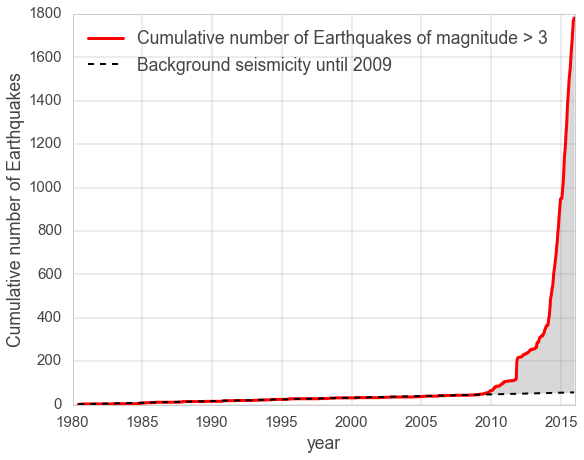

In [6]:
mask = eq_df['prefmag'] >=3
eq_count, base = np.histogram(eq_df[mask]['year_float'], bins = eq_df[mask].shape[0])
# plot the cumulative number of earthquakes of magnitude > 3
plt.figure(figsize = (9,7))
plt.plot(base[:-1], np.cumsum(eq_count), lw=3,c='r', label='Cumulative number of Earthquakes of magnitude > 3' )
mask_time = (eq_df['year_float'] < 2009) & (eq_df['prefmag'] >=3)
eq_2010, base_2010 = np.histogram(eq_df[mask_time]['year_float'], bins = eq_df[mask_time].shape[0])
# fit the earthquake count before 2009 with a 1st order polynomial
# this is the background seismicity rate
fit = np.polyfit(base_2010[:-1],np.cumsum(eq_2010),1)
fit_fn = np.poly1d(fit)
plt.plot(base[:-1],fit_fn(base[:-1]),'k--',label = 'Background seismicity until 2009')
# now fill in between
plt.fill_between(base[:-1], np.cumsum(eq_count), fit_fn(base[:-1]), color='grey', alpha = 0.3);
plt.xlim([1980,2016]);
plt.ylabel('Cumulative number of Earthquakes')
plt.xlabel('year')
plt.legend(loc =2);

# Earthquake clustering and microseismicity

In this section we will apply the DBSCAN algorithm to look at the clustering of earthquakes of magnitude higher than 3 (often felt by people) and the clustering of microseismicity (earthquake of magnitude lower than 2 not felt by people and not damaging).


In [6]:
def compute_dbscan(eq_df,mask, eps, min_samples):

    # Create a subset of the dataframe to work with
    subset = eq_df[mask]

    # ------------------------------------------------------------------------
    # COMPUTE DBSCAN
    # ------------------------------------------------------------------------

    X = []

    for (lat,longi) in zip(subset.latitude,subset.longitude):
        X.append((lat,longi))
    # implement the sparse matrix of distance
    X_dist = np.zeros((len(X),len(X)), dtype = np.float64)
    # select on index
    for i1 in range(len(X)):
        # loop over all the other indices
        for i2 in range(len(X)):
            #  now find the distance 
            if i1 < i2:
                # if i1 = i2 , distance = 0
                X_dist[i1,i2] = great_circle(X[i1],X[i2]).km
                # fill the symetric part of the matrix
                # since distance(x1, x2) = distance(x2, x1)
                X_dist[i2,i1] = X_dist[i1,i2]




    db = DBSCAN(eps= eps , min_samples= min_samples , metric = 'precomputed').fit(X_dist)
    labels = db.labels_
    # Number of clusters in labels, ignoring noise if present.
    # note that noise is when the label is -1
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

    print('Estimated number of clusters: %d' % n_clusters_)

    # ------------------------------------------------------------------------
    # APPEND COLUMN IN DATAFRAME
    # ------------------------------------------------------------------------

    # First determine if macro earthquake or microearthquake
    if subset.prefmag.min() == 3:
        abbreviation = 'M'
    else:
        abbreviation = 'm'

    col_name = 'cluster_' + abbreviation + '_eps_' + str(eps)


    eq_df[col_name] = np.zeros((eq_df.shape[0])) + 100
    c = 0
    for i in range(eq_df.shape[0]):
        if mask[i]:
            # put the label in the corresponding column
            eq_df.loc[i,col_name] = db.labels_[c]
            c += 1
        else:
            eq_df.loc[i,col_name] = np.nan
    return col_name

def plot_cluster_M(eps):
    
    abbreviation = 'M'
    col_name = 'cluster_' + abbreviation + '_eps_' + str(eps)

    # get the set of labels
    if abbreviation == 'M':
        mask = eq_df.prefmag >=3
        various_labels = set(eq_df[mask][col_name])
    else:
        mask = eq_df.prefmag <= 2
        various_labels = set(eq_df[mask][col_name])

    # now plot
    fig = plt.figure(figsize=  (11,9))
    ax = fig.add_subplot(111)
    
    # ---
    # PLOT THE CLUSTERS
    # ---
    n_clusters_ = len(list(various_labels)) - 1
    for i in range(0,len(list(various_labels))):
        if list(various_labels)[i]!=-1:
            ax.scatter(eq_df.longitude[eq_df[col_name] == list(various_labels)[i]], \
                       eq_df.latitude[eq_df[col_name] == list(various_labels)[i]],label=list(various_labels)[i],
                        color = sns.color_palette('hls',n_clusters_)[i], alpha =1, lw = 4);
        else:
            ax.scatter(eq_df.longitude[eq_df[col_name] == list(various_labels)[i]],\
                       eq_df.latitude[eq_df[col_name] == list(various_labels)[i]],label='noise',
                        color = 'k', alpha =0.1, lw=3);
    csfont = {'fontsize':25}
    ax.set_ylabel('Latitude',**csfont);
    ax.set_xlabel('Longitude',**csfont);
    ax.axis(**csfont)
    ax.set_title("Number of clusters: {}".format(n_clusters_),**csfont);

    # ---
    # PLOT SOME CITIES
    # ---


    # add a couple of cities
    cities = pd.read_csv('./tempdata/OK_cities.txt', sep = '\t')
    # add cities
    mask_towns = (cities.Name == 'Oklahoma City') | (cities.Name == 'Prague') | (cities.Name == 'Tulsa') \
        | (cities.Name == 'Ardmore') | (cities.Name == 'Stillwater') \
        | (cities.Name == 'Enid') | (cities.Name == 'Jones') \
        | (cities.Name == 'Cherookee') | (cities.Name == 'Perry') 
    cities_list = ['Oklahoma City','Prague','Tulsa', \
        'Ardmore','Stillwater', 'Enid', 'Jones', 'Cherookee', 'Perry']
    for city in cities_list:
        ax.annotate(city,\
         xy=(cities[cities.Name == city].Longitude.values[0] ,\
            cities[cities.Name == city].Latitude.values[0]),\
         size=20)
    ax.scatter(cities[mask_towns].Longitude.values[:],
        cities[mask_towns].Latitude.values[:], marker = '*', s= 100)
    ax.set_ylim([34,37])
    ax.set_xlim([-99.2,-96])
    ax.tick_params(labelsize=20)
    plt.show()
    
    return

def plot_cluster_m(eps):
    
    abbreviation = 'm'
    col_name = 'cluster_' + abbreviation + '_eps_' + str(eps)

    # get the set of labels
    if abbreviation == 'M':
        mask = eq_df.prefmag >=3
        various_labels = set(eq_df[mask][col_name])
    else:
        mask = eq_df.prefmag <= 2
        various_labels = set(eq_df[mask][col_name])

    # now plot
    fig = plt.figure(figsize=  (11,9))
    ax = fig.add_subplot(111)
    
    # ---
    # PLOT THE CLUSTERS
    # ---
    n_clusters_ = len(list(various_labels)) - 1
    for i in range(0,len(list(various_labels))):
        if list(various_labels)[i]!=-1:
            ax.scatter(eq_df.longitude[eq_df[col_name] == list(various_labels)[i]], \
                       eq_df.latitude[eq_df[col_name] == list(various_labels)[i]],label=list(various_labels)[i],
                        color = sns.color_palette('hls',n_clusters_)[i], alpha =1, lw = 4);
        else:
            ax.scatter(eq_df.longitude[eq_df[col_name] == list(various_labels)[i]],\
                       eq_df.latitude[eq_df[col_name] == list(various_labels)[i]],label='noise',
                        color = 'k', alpha =0.1, lw=3);
    csfont = {'fontsize':25}
    ax.set_ylabel('Latitude',**csfont);
    ax.set_xlabel('Longitude',**csfont);
    ax.axis(**csfont)
    ax.set_title("Number of clusters: {}".format(n_clusters_),**csfont);

    # ---
    # PLOT SOME CITIES
    # ---


    # add a couple of cities
    cities = pd.read_csv('./tempdata/OK_cities.txt', sep = '\t')
    # add cities
    mask_towns = (cities.Name == 'Oklahoma City') | (cities.Name == 'Prague') | (cities.Name == 'Tulsa') \
        | (cities.Name == 'Ardmore') | (cities.Name == 'Stillwater') \
        | (cities.Name == 'Enid') | (cities.Name == 'Jones') \
        | (cities.Name == 'Cherookee') | (cities.Name == 'Perry') 
    cities_list = ['Oklahoma City','Prague','Tulsa', \
        'Ardmore','Stillwater', 'Enid', 'Jones', 'Cherookee', 'Perry']
    for city in cities_list:
        ax.annotate(city,\
         xy=(cities[cities.Name == city].Longitude.values[0] ,\
            cities[cities.Name == city].Latitude.values[0]),\
         size=20)
    ax.scatter(cities[mask_towns].Longitude.values[:],
        cities[mask_towns].Latitude.values[:], marker = '*', s= 100)
    ax.set_ylim([34,37])
    ax.set_xlim([-99.2,-96])
    ax.tick_params(labelsize=20)
    plt.show()
    
    return

In [80]:
# import libraries for DBSCAN
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
# import library for distance calculation
from geopy.distance import great_circle
# ------------------------------------------------------------------------
# LOAD THE DATA, GET A SUBSET MAGNITUDE > 3 AND COUNTY = LINCOLN
# ------------------------------------------------------------------------
eq_df = pd.DataFrame.from_csv('./tempdata/earthquakes_catalog.csv',sep = '|')
mask = (eq_df.prefmag >= 3.0) 
# eps = the distance to search for neighboring points
# min_samples = the minimum the point required to create an individual cluster
for eps in range(5,16):
    compute_dbscan(eq_df,mask, eps = eps, min_samples = 20)   

eps =  5
time to create the distance matrix = 21.3337450027 s
time to run DBSCAN algorithm = 0.03533411026 s
Estimated number of clusters: 19
eps =  6
time to create the distance matrix = 21.3600308895 s
time to run DBSCAN algorithm = 0.0376579761505 s
Estimated number of clusters: 16
eps =  7
time to create the distance matrix = 21.4374010563 s
time to run DBSCAN algorithm = 0.0390491485596 s
Estimated number of clusters: 15
eps =  8
time to create the distance matrix = 21.6927850246 s
time to run DBSCAN algorithm = 0.0414230823517 s
Estimated number of clusters: 11
eps =  9
time to create the distance matrix = 21.4741690159 s
time to run DBSCAN algorithm = 0.0419969558716 s
Estimated number of clusters: 12
eps =  10
time to create the distance matrix = 21.6042759418 s
time to run DBSCAN algorithm = 0.0448338985443 s
Estimated number of clusters: 8
eps =  11
time to create the distance matrix = 21.4244220257 s
time to run DBSCAN algorithm = 0.0438899993896 s
Estimated number of cluste

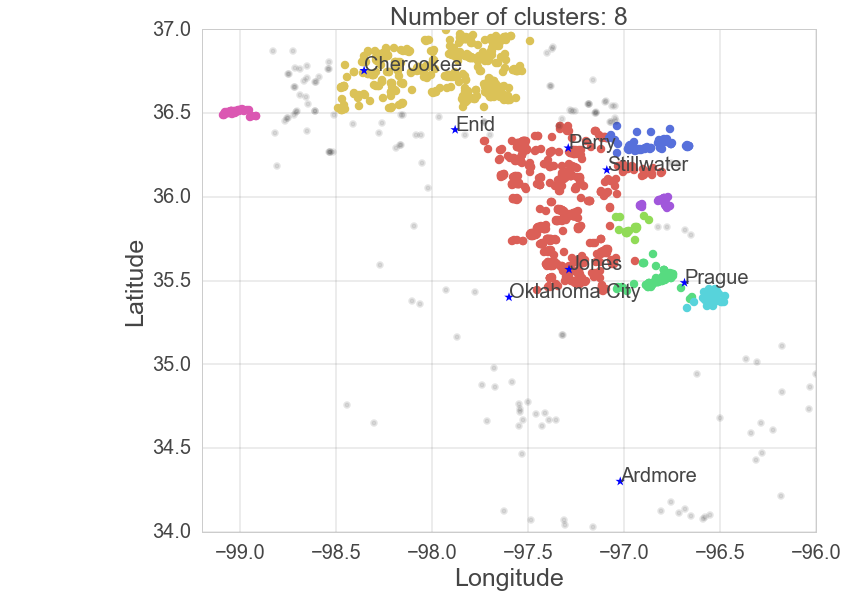

In [7]:
eq_df = pd.DataFrame.from_csv('./tempdata/earthquakes_catalog_treated.csv',sep = '|')
from IPython.html.widgets import interact
global eq_df
interact(plot_cluster_M, eps=(5,15,1));

In [82]:
# Save data frame for future use
eq_df.to_csv('./tempdata/earthquakes_catalog_treated.csv',sep = '|')